# Step 2: Preprocessing

### Load Data

In [1]:
import pandas as pd
import random
import zipfile

# Open the zip file
with zipfile.ZipFile('/yourpath.zip', 'r') as zfile:
    # Get the list of files in the zip archive
    file_list = zfile.namelist()
    
    # Choose a random file from the list
    random_file = random.choice(file_list)
    
    # Read the JSON data from the randomly selected file with lazy loading
    df = pd.read_json(zfile.open(random_file), lines=True, chunksize=50000)
    
    # Take a random sample of 10% of the data
    df = pd.concat([chunk.sample(frac=0.1, random_state=42) for chunk in df])

### Drop irrelevant columns

In [2]:
# Drop columns that do not contribute to the identification of trends in the research papers
df = df.drop(columns=['submitter', 'comments', 'journal-ref', 'report-no', 'license', 'authors'])

### Normalization
The column "versions" is further split into the columns "version" and "created"

In [3]:
# Explode the 'versions' column to separate rows
df_exploded = df.explode('versions')

# Reset the index
df_exploded = df_exploded.reset_index(drop=True)

# Normalize the 'versions' column
df_normalized = pd.json_normalize(df_exploded['versions'])

# Concatenate the normalized 'versions' DataFrame with the original DataFrame
df = pd.concat([df_exploded.drop(columns=['versions']), df_normalized], axis=1)

### Drop duplicates
For each id and each doi, the entry with the latest version is kept as we are only interested in successfully published papers.

In [4]:
# Convert 'version' column to numeric for correct comparison
df['version'] = df['version'].str.extract(r'(\d+)').astype(float)

# Get the index of the row with the highest version for each ID
idx_highest_version = df.groupby('id')['version'].idxmax()

# Filter the DataFrame to keep only the rows with the highest version for each ID
df = df.loc[idx_highest_version]

In [5]:
# Get the index of the row with the highest version for each DOI
idx_highest_version = df.groupby('doi')['version'].idxmax()

# Filter the DataFrame to keep only the rows with the highest version for each DOI
df = df.loc[idx_highest_version]

### Retrieve the year of submission

In [6]:
# Use regex to split 'created' column into date, time, and timezone
df[['created_date', 'created_time', 'created_timezone']] = df['created'].str.extract(r'(\w+, \d+ \w+ \d{4}) (\d+:\d+:\d+) (\w+)$')

df['created_date'] = pd.to_datetime(df['created_date'])

# Extract year from the 'created_date' column
df['created_year'] = df['created_date'].dt.year

# Drop the original 'created' column and 'created_time', 'created_timezone'
df.drop(columns=['created', 'created_time', 'created_timezone'], inplace=True)

### Clean raw abstract text

In [7]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import re


def preprocess_text(text, excluded_words=None):
    # Define a regular expression pattern to match URLs
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    text = url_pattern.sub('', text)
    
    # Convert to lowercase
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove numbers and special characters
    pattern = re.compile('[^a-zA-Z\s]')  # Matches anything that is not a letter or whitespace
    text = pattern.sub('', text)
    
    # Tokenization
    text = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in text if word not in stop_words]
    

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) if word is not None else '' for word in filtered_tokens]
    
    return lemmatized_tokens


# Apply preprocessing to the 'abstract' column
df['abstract'] = df['abstract'].apply(preprocess_text)
df['title'] = df['title'].apply(preprocess_text)

### Conversion of categories
For each sub_category, a column is created and named based on the dictionary from the file categories_data. Additionally, each paper is assigned to its main_category.

In [16]:
# Split the 'categories' column into a list of categories
df['categories_list'] = df['categories'].str.split()

# Determine unique categories across all rows
unique_categories = set(category for categories_list in df['categories_list'] for category in categories_list)

# Create separate binary columns for each unique category
for category in unique_categories:
    df[category] = df['categories_list'].apply(lambda x: int(category in x))
    
# Drop the 'categories_list' column
df.drop(columns=['categories_list'], inplace=True)

In [17]:
# Retrieve the dictionary from the file categories_data using %store
%store -r taxonomy_data

# Iterate through the main categories and add them as columns with initial values of 0
for main_category in taxonomy_data.keys():
    df[main_category] = 0

# Iterate through the main categories and their corresponding subcategories
for main_category, subcategories in taxonomy_data.items():
    #Extract the short names of subcategories for the current main category
    short_names = [subcategory['short_name'] for subcategory in subcategories]
    
    # Update the corresponding main category columns based on the presence of subcategories
    df[main_category] = df[short_names].max(axis=1)

# Fill NaN values in main category columns with 0
df.update(df.filter(items=list(taxonomy_data.keys())).fillna(0))


In [10]:
print(df)

                     id                                              title  \
253701       2110.11133  [newtontype, method, simultaneous, matrix, dia...   
245671       2106.10944  [hard, hat, wearing, detection, based, head, k...   
278193       2208.07425  [contextuality, complementarity, signaling, be...   
191958       1908.01593  [high, accuracy, tumor, diagnosis, benchmarkin...   
381829  physics/9812049              [molecular, calculation, b, function]   
...                 ...                                                ...   
264329       2204.07057  [hate, speech, classification, using, svm, nai...   
244198       2104.14414              [regional, poverty, bulgaria, period]   
125952       1608.00426  [epsiloncapacity, gain, matrix, tolerable, dis...   
314177        2310.1188  [online, convex, optimization, switching, cost...   
297297       2304.03859                [threedimensional, soft, streaming]   

                                                      doi  \
25

## Descriptive Statistics

### Distribution of published papers over the years
This visualization displays the total number of publications for each year

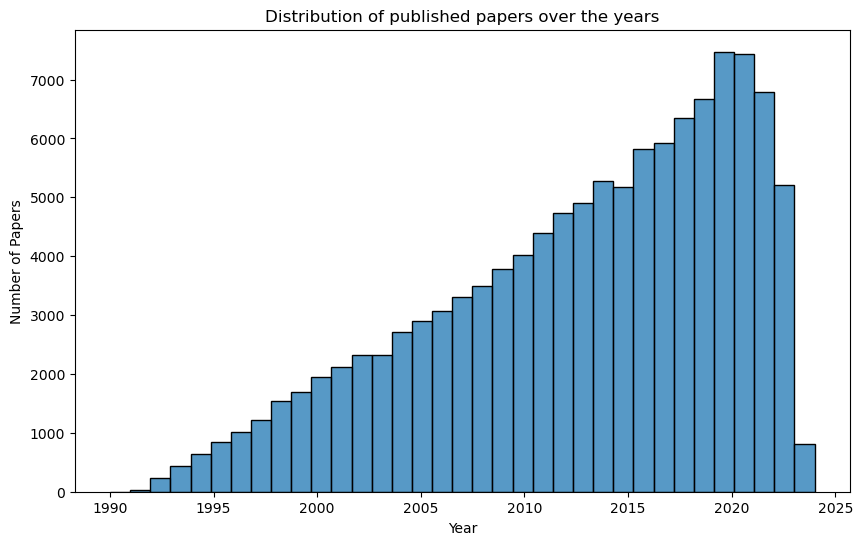

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the distribution of rows based on the year in the 'created_date' column
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='created_year', bins=len(df['created_year'].unique()))
plt.title('Distribution of published papers over the years')
plt.xlabel('Year')
plt.ylabel('Number of Papers')
plt.show()

### Development of number of journals for each main category over the years
This visualization displays for each year and main category the number of publications.

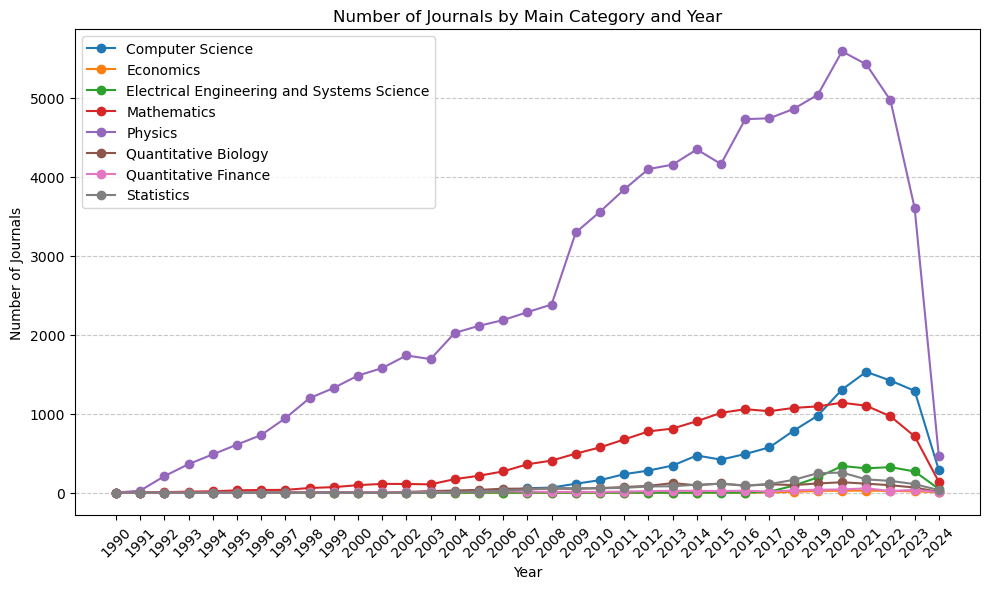

In [12]:
import numpy as np

# Convert final_data keys to a list
main_category_keys = list(taxonomy_data.keys())

# Group by 'created_year' and sum the counts for each main category
main_category_counts = df.groupby('created_year')[main_category_keys].sum()

# Plot the bar charts for each main category
plt.figure(figsize=(10, 6))
for category in main_category_keys:
    plt.plot(main_category_counts.index, main_category_counts[category], label=category, marker='o')

plt.title('Number of Journals by Main Category and Year')
plt.xlabel('Year')
plt.ylabel('Number of Journals')
plt.xticks(np.unique(main_category_counts.index), rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Top 5 subcategories with the highest number of published research papers
This visualization displays for each main category the five sub-categories with the highest number of publications

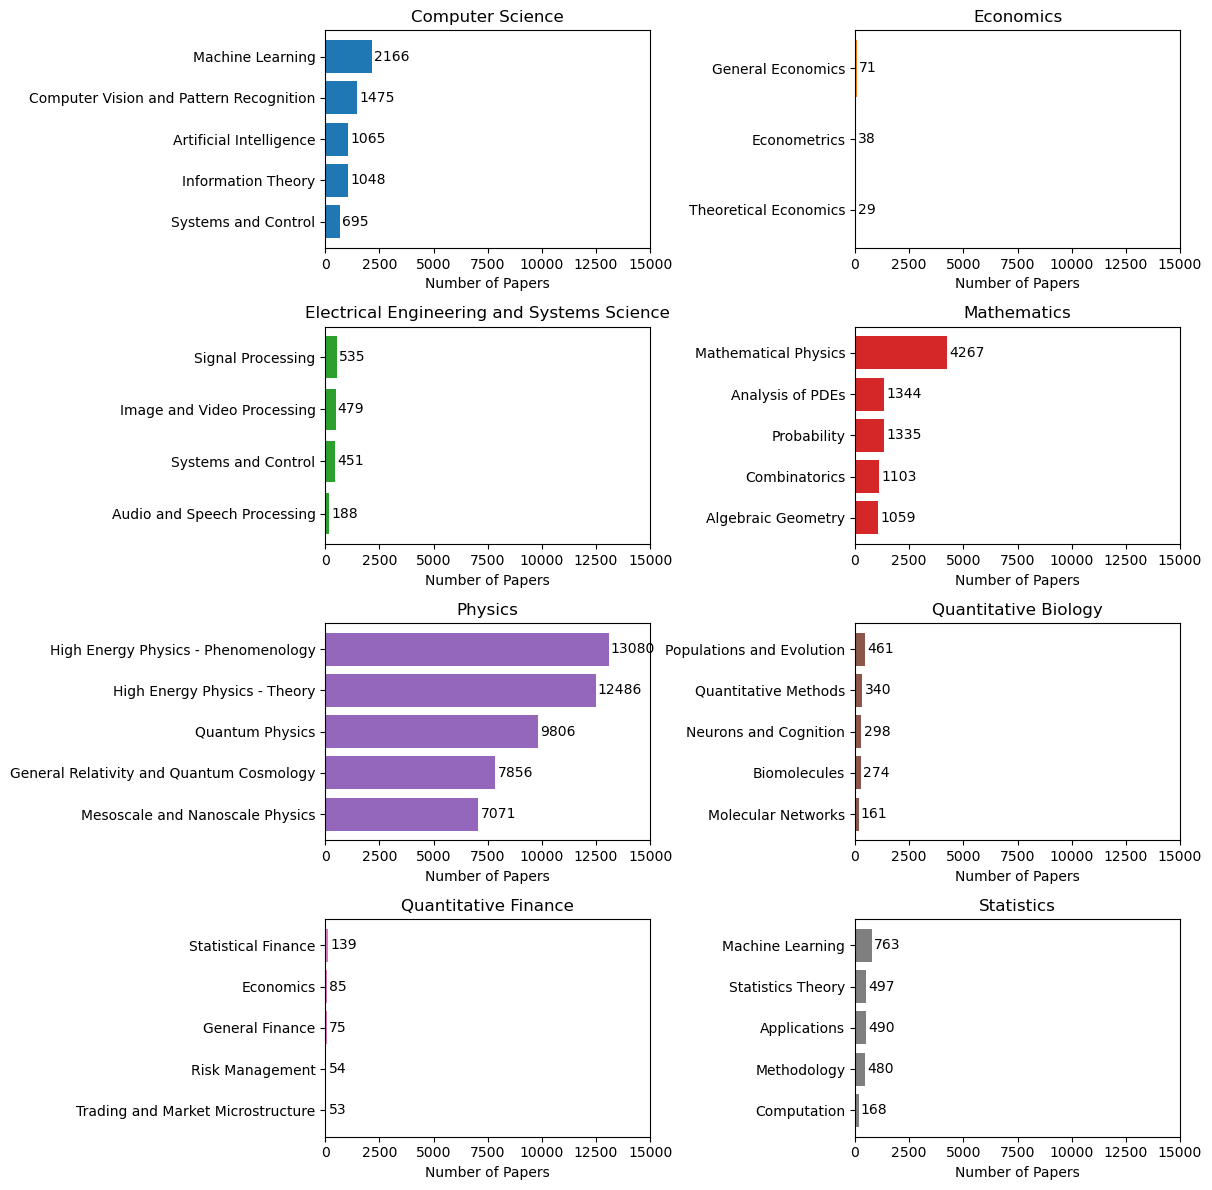

In [13]:
# Get the default color cycle
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Dictionary to store the top five subcategories for each main category
top_five_subcategories_main_category = {}

# Find the top five subcategories for each main category
for main_category, subcategories in taxonomy_data.items():
    # Get all the subcategory short names for the current main category
    subcategory_short_names = [subcategory['short_name'] for subcategory in subcategories]
    
    # Find the subcategory columns in the DataFrame for the current main category
    subcategory_columns = [column for column in df.columns if column in subcategory_short_names]
    
    # Group by the subcategory columns and sum the values for the current main category
    subcategory_sums = df[subcategory_columns].sum()
    
    # Sort the sums in descending order and select the top five subcategories for the current main category
    top_five_subcategories_with_long_names = subcategory_sums.nlargest(5).rename(index={subcategory['short_name']: subcategory['long_name'] 
                                                                                      for subcategory in subcategories})
    
    # Store the top five subcategories for the current main category in the dictionary
    top_five_subcategories_main_category[main_category] = top_five_subcategories_with_long_names


# Create bar charts for each main category pair
fig, axs = plt.subplots(nrows=8// 2, ncols=2, figsize=(12, 12))

# Create an iterator for the taxonomy data keys
main_category_iter = iter(taxonomy_data.keys())

# Iterate through main category pairs and plot the bar charts with colors
for i, ax_row in enumerate(axs):
    for j, ax in enumerate(ax_row):
        main_category = next(main_category_iter)
        top_five_subcategories = top_five_subcategories_main_category[main_category]
        category_color = colors[i * 2 + j]  # Get color from the default color cycle
        top_five_subcategories_sorted = top_five_subcategories.sort_values(ascending=False)
        bars = ax.barh(top_five_subcategories_sorted.index, top_five_subcategories_sorted.values, color=category_color)
        ax.set_xlabel('Number of Papers')
        ax.set_ylabel('')
        ax.set_title(f'{main_category}')
        ax.invert_yaxis()
        # Set fixed x-axis length
        ax.set_xlim(0, 15000)
        
        # Annotate each bar with its value
        for bar in bars:
            width = bar.get_width()
            label_x = bar.get_width() + 100
            label_y = bar.get_y() + bar.get_height() / 2
            ax.text(label_x, label_y, f'{int(width)}', va='center')

# Adjust layout
plt.tight_layout()
plt.show()

In [14]:
# Selection of category "Machine Learning" for further clustering and analysis
df = df[(df['cs.LG'] == 1) & (df['created_year'] < 2024)]
len(df)

2102

In [15]:
# Store the dataframe using %store
%store df

Stored 'df' (DataFrame)
